# Deep Neural Collaborative Filtering

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [4]:
%matplotlib inline

## Prepare the data

In [6]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [7]:
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [8]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [9]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [10]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(np.int64(1), np.int64(5))

In [11]:
train, test = user_split(DATA, "timestamp", "user_id", [0.8, 0.2])

In [12]:
train.shape, test.shape

((80000, 7), (20000, 7))

# Deep Neural CF

In [14]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
from reco import vis

In [15]:
def Neural_CF(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    
    # Item Embedding MF
    item_embedding_mf = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                  embeddings_initializer='he_normal',
                                  name='ItemEmbeddingMF')(item_input)
    item_vec_mf = Flatten(name='FlattenItemMF')(item_embedding_mf)
    
    
    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                embeddings_initializer='he_normal',
                               name='ItemEmbeddingMLP')(item_input)
    item_vec_mlp = Flatten(name='FlattenItemMLP')(item_embedding_mlp)
    

    # User Layer
    user_input = Input(shape=[1], name='User')
    
    # User Embedding MF
    user_embedding_mf = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), 
                                embeddings_initializer='he_normal',
                               name='UserEmbeddingMF')(user_input)
    user_vec_mf = Flatten(name='FlattenUserMF')(user_embedding_mf)
    
    # User Embedding MF
    user_embedding_mlp = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='he_normal',
                               name='UserEmbeddingMLP')(user_input)
    user_vec_mlp = Flatten(name='FlattenUserMLP')(user_embedding_mlp)
    
    # Multiply MF paths
    DotProductMF = Dot(axes=1, name='DotProductMF')([item_vec_mf, user_vec_mf])
    
    # Concat MLP paths
    ConcatMLP = Concatenate(name='ConcatMLP')([item_vec_mlp, user_vec_mlp])
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(50, name="Dense1")(ConcatMLP)
    Dense_2 = Dense(20, name="Dense2")(Dense_1)

    # Concatenate MF and MLP paths
    Concat = Concatenate(name="ConcatAll")([DotProductMF, Dense_2])
    
    # Use Dense to learn non-linear dense representation
    Pred = Dense(1, name="Pred")(Concat)
    

    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Pred with bias added
    PredAddBias = Add(name="AddBias")([Pred, item_bias_vec, user_bias_vec])
    
    
    # Scaling for each user
    y = Activation('sigmoid')(PredAddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [16]:
n_factors = 40
model = Neural_CF(n_users, n_items, n_factors)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemEmbeddingMLP    │ (None, 1, 40)     │     67,280 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserEmbeddingMLP    │ (None, 1, 40)     │     37,720 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemMLP      │ (None, 40)        │          0 │ ItemEmbeddingMLP… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUserMLP      │ (None, 40)        │          0 │ UserEmbeddingMLP… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemEmbeddingMF     │ (None, 1, 40)     │     67,280 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserEmbeddingMF     │ (None, 1, 40)     │     37,720 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConcatMLP           │ (None, 80)        │          0 │ FlattenItemMLP[0… │
│ (Concatenate)       │                   │            │ FlattenUserMLP[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemMF       │ (None, 40)        │          0 │ ItemEmbeddingMF[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUserMF       │ (None, 40)        │          0 │ UserEmbeddingMF[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 50)        │      4,050 │ ConcatMLP[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DotProductMF (Dot)  │ (None, 1)         │          0 │ FlattenItemMF[0]… │
│                     │                   │            │ FlattenUserMF[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense2 (Dense)      │ (None, 20)        │      1,020 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConcatAll           │ (None, 21)        │          0 │ DotProductMF[0][… │
│ (Concatenate)       │                   │            │ Dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemBias            │ (None, 1, 1)      │      1,682 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserBias            │ (None, 1, 1)      │        943 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pred (Dense)        │ (None, 1)         │         22 │ ConcatAll[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 217,717 (850.46 KB)

 Trainable params: 217,717 (850.46 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists d:\Work\Development\recommendation_system/model-img


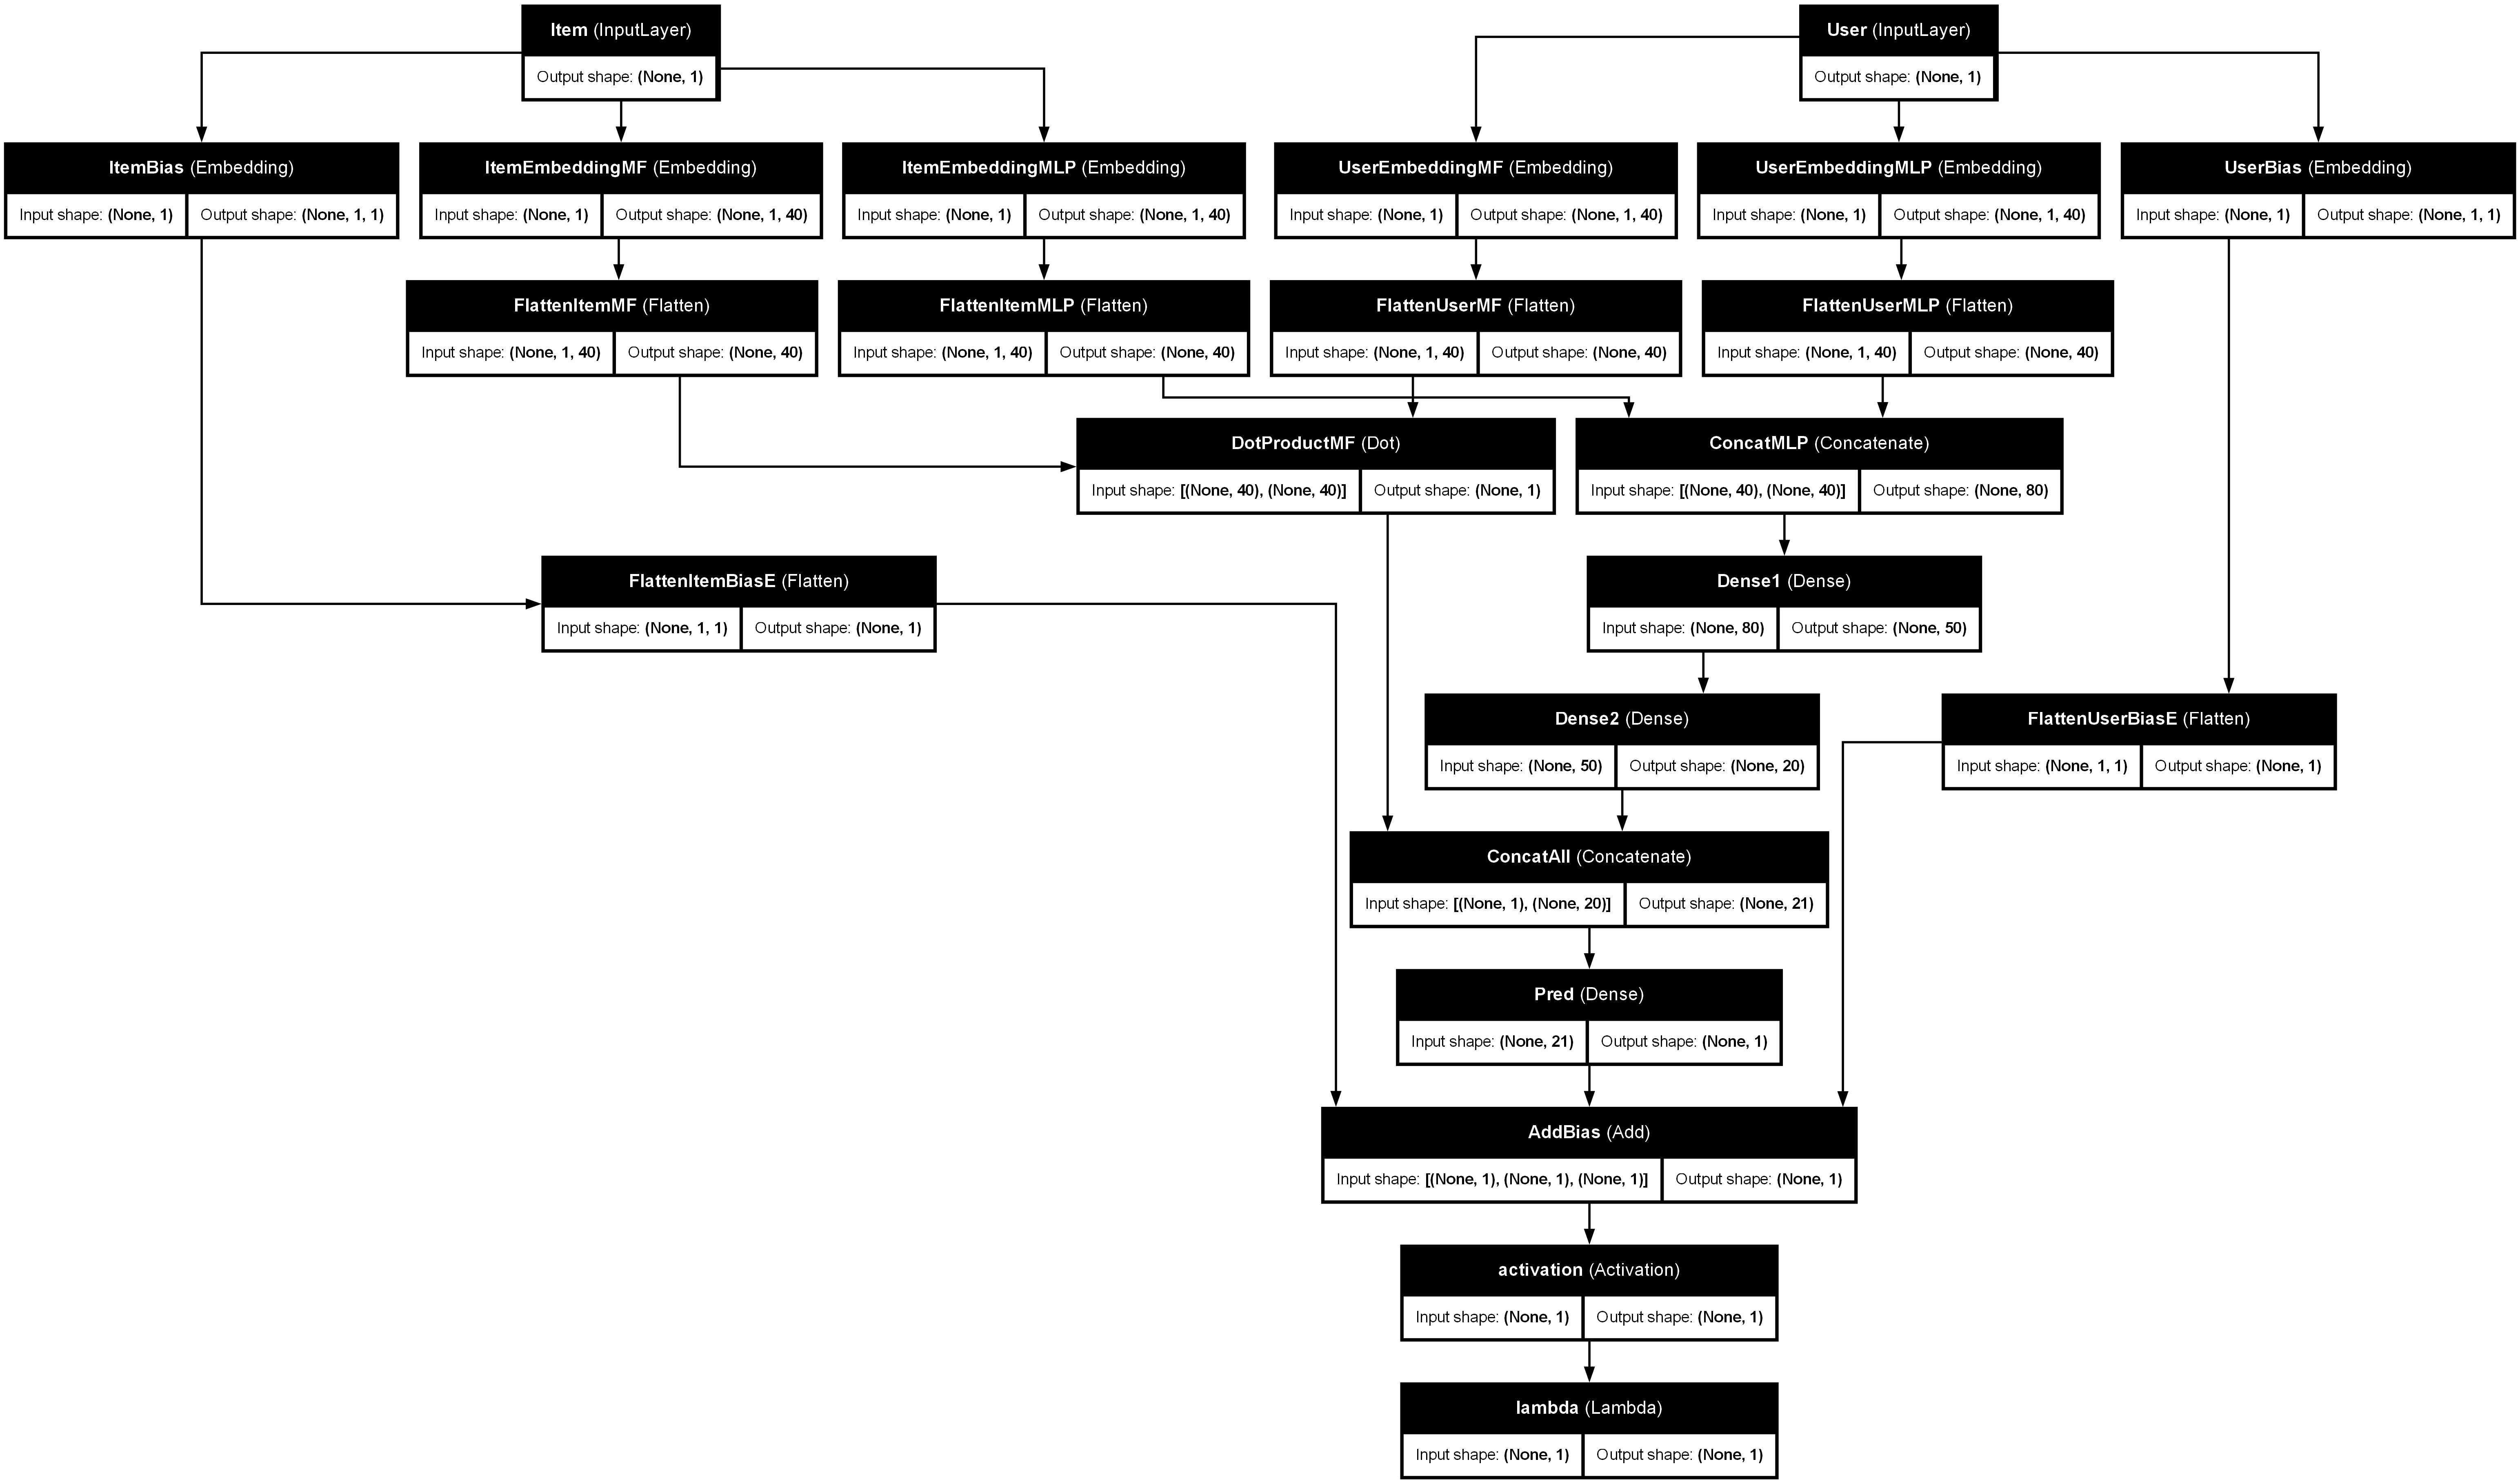

In [19]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/Neural-CF.png" )

## Train the model

In [20]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0913 - val_loss: 1.0094
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8725 - val_loss: 1.0096
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7475 - val_loss: 1.0067
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5182 - val_loss: 1.0140
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3681 - val_loss: 1.0095
CPU times: total: 21 s
Wall time: 7.81 s


In [21]:
vis.metrics(output.history)

alt.FacetChart(...)

## Score the model

In [22]:

score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9898


0.9974839091300964

## Evaluate the model

In [23]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [24]:
item_embedding_mf = get_embedding(model, "ItemEmbeddingMF")
user_embedding_mf = get_embedding(model, "UserEmbeddingMF")
item_embedding_mlp = get_embedding(model, "ItemEmbeddingMLP")
user_embedding_mlp = get_embedding(model, "UserEmbeddingMLP")

In [25]:
item_embedding = np.mean([item_embedding_mf,item_embedding_mlp], axis=0)
user_embedding = np.mean([user_embedding_mf,user_embedding_mlp], axis=0)

In [26]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 41s 818us/step
CPU times: total: 1min 23s
Wall time: 59.5 s


In [27]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,3.898921
1,195,301,4.106472
2,195,376,2.503280
3,195,50,3.485200
4,195,345,3.904268


In [28]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 33s 668us/step
CPU times: total: 1min 6s
Wall time: 46.5 s


In [29]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.068456
Precision@K:	0.047296
Recall@K:	0.021995


## Get similar items

In [30]:
from reco.recommend import get_similar, show_similar

In [31]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: total: 93.8 ms
Wall time: 92.2 ms


In [32]:
item_similar_indices

array([[   0, 1463, 1450, 1487, 1543],
       [   1, 1405, 1540, 1320, 1278],
       [   2, 1495, 1480, 1307, 1528],
       ...,
       [1679, 1493, 1365, 1672, 1550],
       [1680, 1365, 1672, 1659, 1143],
       [1681, 1670, 1678, 1658, 1603]])

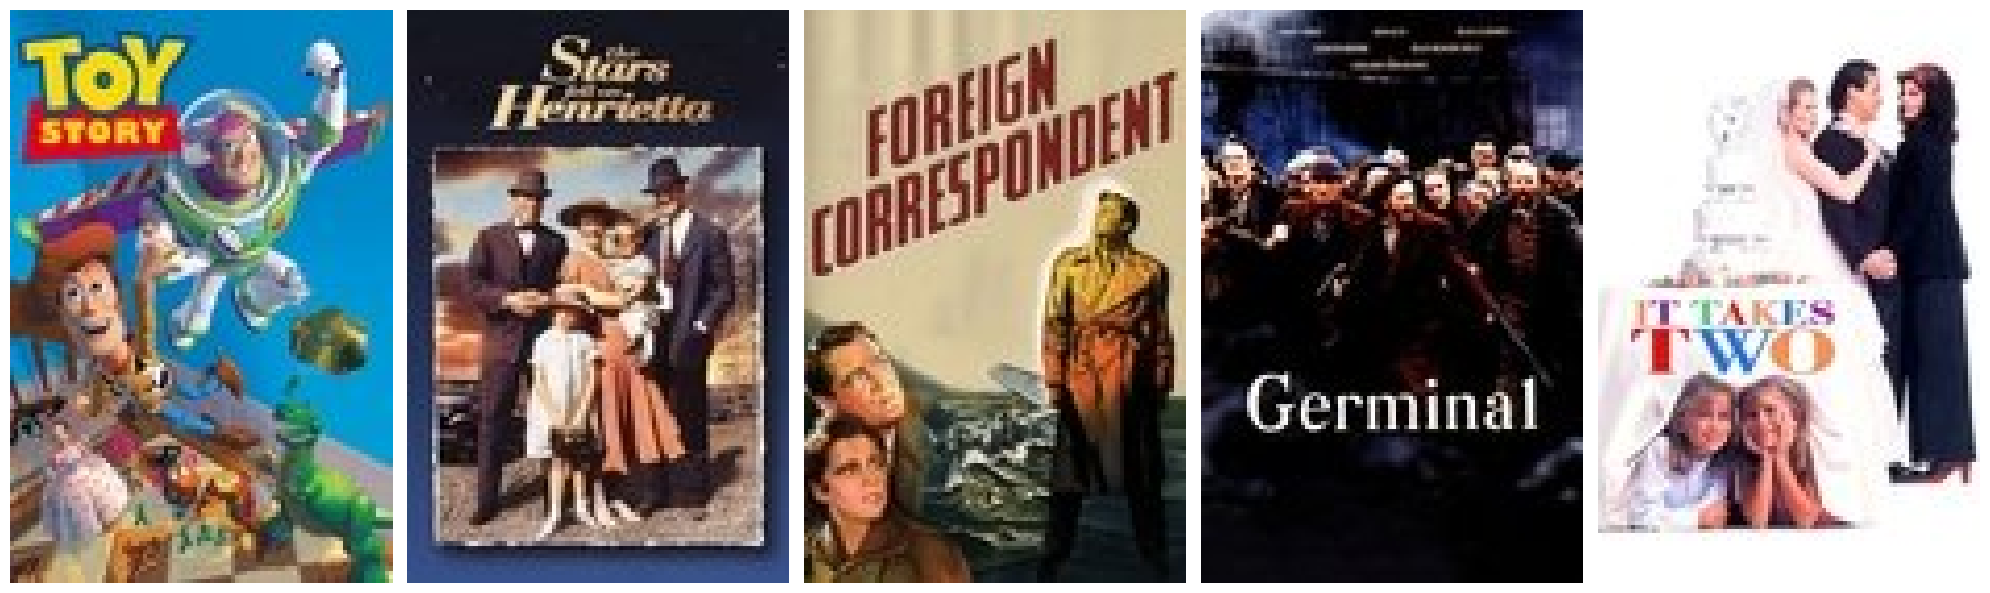

In [33]:
show_similar(0, item_similar_indices, item_encoder)